## **Import Dependencies**

In [39]:
import os
import pickle
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts

from tqdm import tqdm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

## **Read the Dataset**

In [40]:
data = pd.read_csv("/content/ASII.csv")

column_to_drop = ["previous", "open_price", "first_trade", "high", "low", "delisting_date"]
data = data.drop(column_to_drop, axis=1)
data.head()

,date,close,change,volume,value,frequency,index_individual,offer,offer_volume,bid,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,non_regular_volume,non_regular_value,non_regular_frequency
0,2019-07-29T00:00:00,7175.0,100.0,18841000.0,1.344756e+11,3859.0,5131.0,7175.0,633400.0,7150.0,1600.0,4.048355e+10,4.048355e+10,4.048355e+10,12745600.0,9583800.0,2808700.0,1.995158e+10,7.0
1,2019-07-30T00:00:00,7275.0,100.0,30765800.0,2.220982e+11,4420.0,5202.5,7275.0,1122400.0,7225.0,162000.0,4.048355e+10,4.048355e+10,4.048355e+10,17320100.0,15540300.0,4249420.0,3.027105e+10,25.0
2,2019-07-31T00:00:00,7000.0,-275.0,61515300.0,4.324626e+11,11015.0,5005.8,7025.0,110200.0,7000.0,6532400.0,4.048355e+10,4.048355e+10,4.048355e+10,50801800.0,16316900.0,54680952.0,3.850957e+11,45.0
3,2019-08-01T00:00:00,7025.0,25.0,37270900.0,2.619394e+11,5176.0,5023.7,7050.0,514800.0,7025.0,2984200.0,4.048355e+10,4.048355e+10,4.048355e+10,25471600.0,27668200.0,31364378.0,2.208941e+11,19.0
4,2019-08-02T00:00:00,7075.0,50.0,40942800.0,2.884855e+11,5182.0,5059.5,7100.0,3721700.0,7075.0,700.0,4.048355e+10,4.048355e+10,4.048355e+10,26615000.0,27470700.0,14526329.0,1.030492e+11,13.0


## **Understanding the Dataset**

In [41]:
# Check the percentage of Nan in dataset
total        = data.isnull().sum().sort_values(ascending=False)
percent      = (data.isnull().sum() / len(data)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(15)

,Total,Percent
date,0,0.0
bid_volume,0,0.0
non_regular_value,0,0.0
non_regular_volume,0,0.0
foreign_buy,0,0.0
foreign_sell,0,0.0
weight_for_index,0,0.0
tradeble_shares,0,0.0
listed_shares,0,0.0
bid,0,0.0


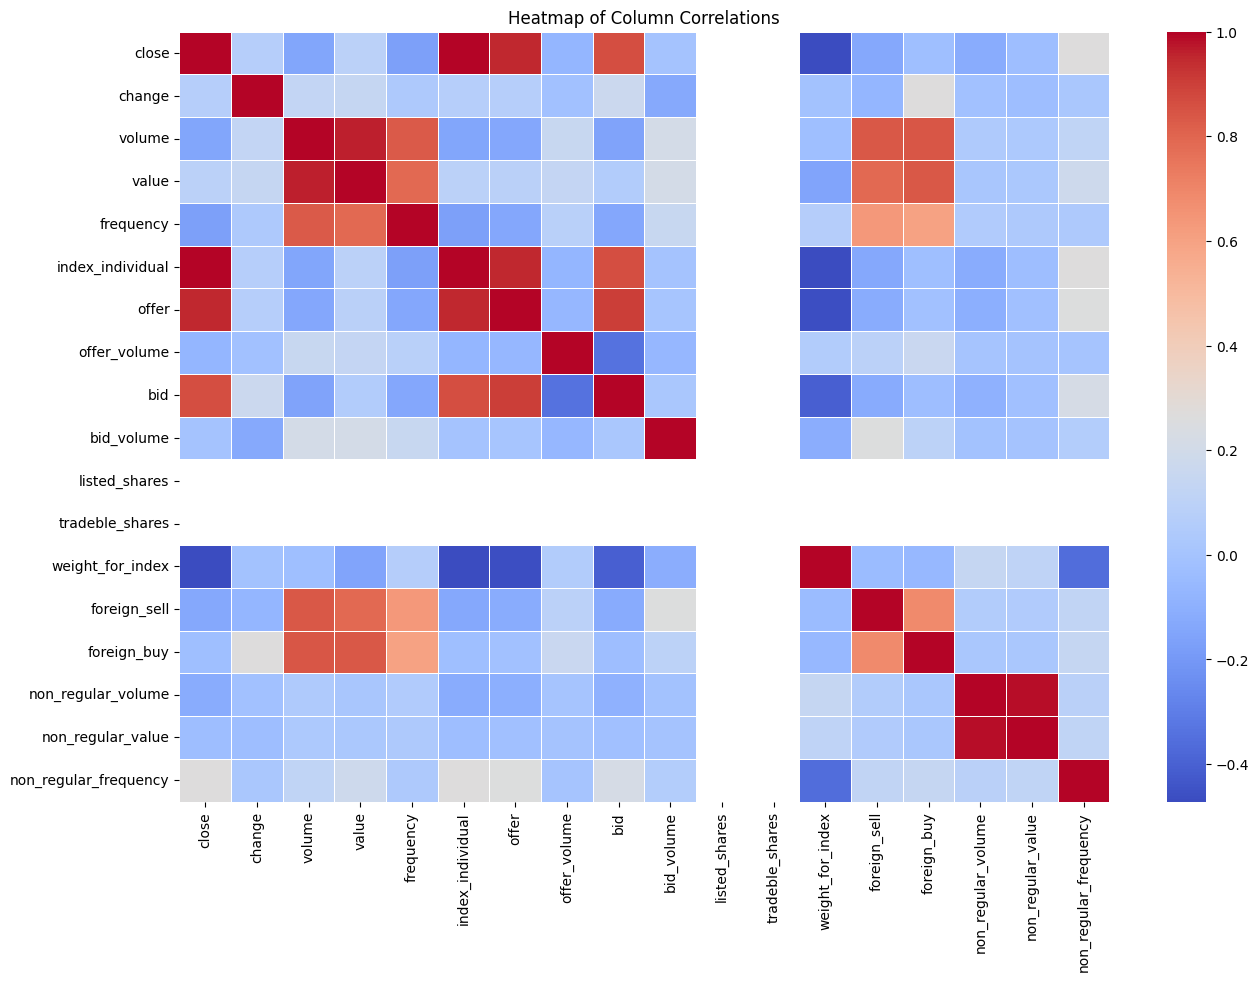

In [42]:
def visualize_heatmap(data):
    """
    Visualize a heatmap of the correlation matrix for the DataFrame.

    Parameters:
    - data (pd.DataFrame): The DataFrame for which the heatmap is generated.

    Returns:
    None
    """
    # Calculate the correlation matrix
    correlation_matrix = data.corr()

    # Set the size of the figure
    plt.figure(figsize=(15, 10))

    # Display the heatmap
    sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f', linewidths=0.5)

    # Adjust the layout
    plt.title('Heatmap of Column Correlations')
    plt.show()

# Call the function to display the heatmap
visualize_heatmap(data)

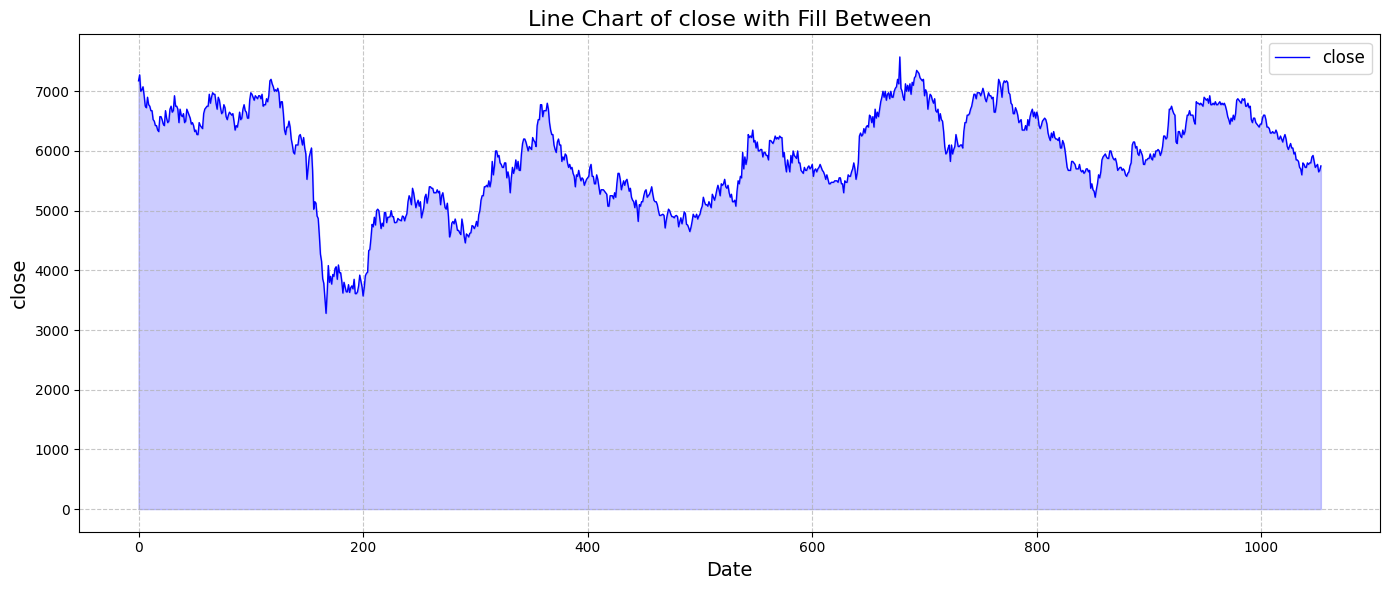

In [43]:
def visualize_timeframe(data, target_column="close"):
    """
    Visualize the target column using a line chart with fill between.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_column (str, optional): The column to visualize. Default is target.

    Returns:
    None
    """
    # Set the size of the figure
    plt.figure(figsize=(14, 6))

    # Create a line chart for target
    plt.plot(data.index, data[target_column], label=target_column, color='blue', linestyle='-', linewidth=1)

    # Add fill between the line and the x-axis
    plt.fill_between(data.index, data[target_column], color='blue', alpha=0.2)

    # Add labels and title
    plt.xlabel('Date', fontsize=14)
    plt.ylabel(target_column, fontsize=14)
    plt.title(f'Line Chart of {target_column} with Fill Between', fontsize=16)

    # Add a legend
    plt.legend(fontsize=12)

    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust the layout
    plt.tight_layout()
    plt.show()

# Visualize the close price
visualize_timeframe(data)

## **Preprocessing the Dataset**

In [44]:
# Mengonversi kolom 'date' menjadi tipe data datetime
data['date'] = pd.to_datetime(data['date'])

# Menjadikan kolom 'date' sebagai indeks
data.set_index('date', inplace=True)
data.head()

,close,change,volume,value,frequency,index_individual,offer,offer_volume,bid,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,non_regular_volume,non_regular_value,non_regular_frequency
date,,,,,,,,,,,,,,,,,,
2019-07-29,7175.0,100.0,18841000.0,1.344756e+11,3859.0,5131.0,7175.0,633400.0,7150.0,1600.0,4.048355e+10,4.048355e+10,4.048355e+10,12745600.0,9583800.0,2808700.0,1.995158e+10,7.0
2019-07-30,7275.0,100.0,30765800.0,2.220982e+11,4420.0,5202.5,7275.0,1122400.0,7225.0,162000.0,4.048355e+10,4.048355e+10,4.048355e+10,17320100.0,15540300.0,4249420.0,3.027105e+10,25.0
2019-07-31,7000.0,-275.0,61515300.0,4.324626e+11,11015.0,5005.8,7025.0,110200.0,7000.0,6532400.0,4.048355e+10,4.048355e+10,4.048355e+10,50801800.0,16316900.0,54680952.0,3.850957e+11,45.0
2019-08-01,7025.0,25.0,37270900.0,2.619394e+11,5176.0,5023.7,7050.0,514800.0,7025.0,2984200.0,4.048355e+10,4.048355e+10,4.048355e+10,25471600.0,27668200.0,31364378.0,2.208941e+11,19.0
2019-08-02,7075.0,50.0,40942800.0,2.884855e+11,5182.0,5059.5,7100.0,3721700.0,7075.0,700.0,4.048355e+10,4.048355e+10,4.048355e+10,26615000.0,27470700.0,14526329.0,1.030492e+11,13.0


In [45]:
# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Mengambil kolom yang akan dinormalisasi
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Melakukan normalisasi untuk kolom-kolom numerik
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
data.head()

,close,change,volume,value,frequency,index_individual,offer,offer_volume,bid,bid_volume,listed_shares,tradeble_shares,weight_for_index,foreign_sell,foreign_buy,non_regular_volume,non_regular_value,non_regular_frequency
date,,,,,,,,,,,,,,,,,,
2019-07-29,0.906868,0.675676,0.037468,0.053083,0.062591,0.906883,0.944079,0.019541,0.943894,0.000039,0.0,0.0,1.0,0.065525,0.050705,0.014953,0.020619,0.067961
2019-07-30,0.930151,0.675676,0.076701,0.107481,0.074587,0.930162,0.957237,0.034627,0.953795,0.003917,0.0,0.0,1.0,0.089288,0.086421,0.022623,0.031283,0.242718
2019-07-31,0.866123,0.337838,0.177867,0.238080,0.215615,0.866120,0.924342,0.003400,0.924092,0.157955,0.0,0.0,1.0,0.263219,0.091078,0.291106,0.397970,0.436893
2019-08-01,0.871944,0.608108,0.098103,0.132215,0.090754,0.871948,0.927632,0.015882,0.927393,0.072159,0.0,0.0,1.0,0.131634,0.159143,0.166975,0.228279,0.184466
2019-08-02,0.883586,0.630631,0.110184,0.148696,0.090882,0.883604,0.934211,0.114817,0.933993,0.000017,0.0,0.0,1.0,0.137574,0.157959,0.077334,0.106494,0.126214


## **Feature Selection**

In [46]:
# Initialize min_test_MSE and best_columns
min_test_MSE = float('inf')
best_columns = None
best_lags    = 0
target       = "close"

# Search best feature with iteration
for i in tqdm(range(2000), desc="Processing", unit="iteration"):
    try:
        # Choose random features
        selected_data = data.sample(n=random.randint(2, 2 + int(i/200)), axis=1, replace=False)
        selected_data[target] = data[target]
        data_ = selected_data.copy()

        # Sort index
        data_ = data_.sort_index(ascending=True)

        # Split data
        data_train = data_[:int(0.8*len(data_))]
        data_test  = data_[int(0.8*len(data_)):]

        # Fit VAR model to the training data
        model = VAR(data_train)
        lag_selection_VAR = model.select_order(maxlags=20 - int(i/200))

        # Get the lag order
        lag_order = lag_selection_VAR.selected_orders['aic']
        model_fitted = model.fit(lag_order)

        # Number of predicted time steps
        steps = len(data_test) + 100

        # Predict use VAR model
        forecast       = model_fitted.forecast(data_train.values, steps = steps)
        forecast_index = pd.date_range(start=data_train.index[-1], freq='B', periods=steps + 1)[1:]
        forecast_data  = pd.DataFrame(forecast, index=forecast_index, columns=data_train.columns)

        # Calculate residuals (errors) on the training data
        train_residuals = data_train[lag_order:][target] - model_fitted.fittedvalues.values[:, -1]
        test_residuals = data_test[target] - forecast_data[target]

        # Calculate Mean Squared Error (MSE) for each variable
        train_MSE = mean_squared_error(data_train[lag_order:][target], model_fitted.fittedvalues.values[:, -1])
        test_MSE = mean_squared_error(data_test[target], forecast_data[:-100][target])

        # Check if current test_MSE is the smallest
        if test_MSE < min_test_MSE:
            min_test_MSE = test_MSE
            best_columns = data_.columns.tolist()
            best_lags    = lag_order

    except Exception as e:
        i = i - 1
        print(f"\n -- An error occurred: {e}")

# Print the columns with the smallest test_MSE
print(f"\n\nBest columns with the smallest test_MSE is {best_columns} with lags {best_lags}")
print(f"Smallest test_MSE value: {min_test_MSE}")

Processing:   0%|          | 4/2000 [00:00<01:24, 23.55iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:   1%|          | 12/2000 [00:00<01:28, 22.57iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:   1%|          | 18/2000 [00:00<01:34, 21.00iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:   1%|          | 21/2000 [00:00<01:40, 19.79iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:   1%|▏         | 28/2000 [00:01<02:47, 11.75iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:   2%|▏         | 35/2000 [00:02<04:19,  7.57iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:   2%|▏         | 49/2000 [00:04<03:06, 10.48iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:   3%|▎         | 54/2000 [00:05<02:33, 12.66iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:   3%|▎         | 61/2000 [00:05<02:01, 15.99iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:   3%|▎         | 66/2000 [00:05<02:07, 15.12iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:   3%|▎         | 69/2000 [00:06<02:03, 15.58iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:   4%|▍         | 88/2000 [00:07<02:04, 15.41iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:   5%|▍         | 97/2000 [00:08<02:06, 14.99iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:   5%|▌         | 109/2000 [00:08<02:10, 14.51iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:   6%|▌         | 119/2000 [00:09<02:00, 15.60iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:   6%|▋         | 130/2000 [00:10<01:34, 19.70iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:   7%|▋         | 137/2000 [00:10<01:56, 15.92iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:   7%|▋         | 145/2000 [00:11<01:56, 15.95iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:   8%|▊         | 153/2000 [00:11<01:57, 15.71iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:   8%|▊         | 161/2000 [00:12<01:55, 15.94iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:   8%|▊         | 165/2000 [00:12<01:58, 15.50iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:   9%|▉         | 178/2000 [00:13<02:11, 13.89iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  10%|▉         | 192/2000 [00:14<02:19, 12.99iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  10%|▉         | 196/2000 [00:15<02:54, 10.32iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  10%|█         | 201/2000 [00:15<02:41, 11.11iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  10%|█         | 210/2000 [00:16<03:13,  9.24iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  11%|█         | 215/2000 [00:17<03:27,  8.62iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  11%|█         | 217/2000 [00:17<03:47,  7.84iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  11%|█▏        | 225/2000 [00:18<02:14, 13.24iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  11%|█▏        | 228/2000 [00:18<02:02, 14.45iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  12%|█▏        | 235/2000 [00:18<01:36, 18.24iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  12%|█▏        | 248/2000 [00:19<01:44, 16.78iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  13%|█▎        | 259/2000 [00:20<01:35, 18.16iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  13%|█▎        | 263/2000 [00:20<01:27, 19.77iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  13%|█▎        | 269/2000 [00:20<01:30, 19.12iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  14%|█▍        | 277/2000 [00:21<01:44, 16.50iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  14%|█▍        | 288/2000 [00:22<01:58, 14.50iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  15%|█▍        | 293/2000 [00:22<01:55, 14.73iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  15%|█▍        | 299/2000 [00:22<01:44, 16.29iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  15%|█▌        | 304/2000 [00:22<01:39, 16.98iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  15%|█▌        | 308/2000 [00:23<01:41, 16.66iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  16%|█▌        | 313/2000 [00:23<01:47, 15.72iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  16%|█▌        | 319/2000 [00:23<01:44, 16.10iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  16%|█▋        | 326/2000 [00:24<01:46, 15.76iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  17%|█▋        | 336/2000 [00:25<01:44, 15.87iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  17%|█▋        | 341/2000 [00:25<01:40, 16.49iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  18%|█▊        | 350/2000 [00:26<01:54, 14.38iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  18%|█▊        | 356/2000 [00:26<01:40, 16.37iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  18%|█▊        | 359/2000 [00:26<01:38, 16.67iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  18%|█▊        | 366/2000 [00:27<01:48, 15.08iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  19%|█▊        | 374/2000 [00:27<01:56, 13.95iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  19%|█▉        | 383/2000 [00:28<02:51,  9.44iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  19%|█▉        | 389/2000 [00:29<03:16,  8.18iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  20%|█▉        | 394/2000 [00:30<03:05,  8.65iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  20%|█▉        | 397/2000 [00:30<03:10,  8.40iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  20%|██        | 403/2000 [00:31<02:05, 12.69iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  21%|██        | 415/2000 [00:32<01:42, 15.45iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  21%|██        | 423/2000 [00:32<01:11, 22.12iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  22%|██▏       | 432/2000 [00:32<01:25, 18.44iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  22%|██▏       | 439/2000 [00:33<01:00, 25.80iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  22%|██▏       | 448/2000 [00:33<01:14, 20.80iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  23%|██▎       | 458/2000 [00:34<01:38, 15.59iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  24%|██▎       | 471/2000 [00:35<01:24, 18.15iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

Processing:  24%|██▍       | 478/2000 [00:35<01:01, 24.58iteration/s]



 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  24%|██▍       | 481/2000 [00:35<01:06, 22.95iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  24%|██▍       | 487/2000 [00:35<01:18, 19.31iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  25%|██▌       | 501/2000 [00:36<01:32, 16.17iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  26%|██▌       | 510/2000 [00:37<01:22, 18.07iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  26%|██▌       | 515/2000 [00:37<01:09, 21.48iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  26%|██▌       | 523/2000 [00:37<01:10, 20.94iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  27%|██▋       | 534/2000 [00:38<01:23, 17.52iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  27%|██▋       | 540/2000 [00:38<01:17, 18.83iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  27%|██▋       | 546/2000 [00:39<01:21, 17.94iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  28%|██▊       | 556/2000 [00:39<01:12, 19.94iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  28%|██▊       | 562/2000 [00:39<01:10, 20.37iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  28%|██▊       | 565/2000 [00:40<01:12, 19.73iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  29%|██▊       | 574/2000 [00:40<01:15, 18.97iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  29%|██▉       | 579/2000 [00:40<01:22, 17.25iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  29%|██▉       | 583/2000 [00:41<02:00, 11.79iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  29%|██▉       | 587/2000 [00:41<02:08, 10.99iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  30%|██▉       | 594/2000 [00:42<02:21,  9.95iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  30%|██▉       | 598/2000 [00:43<02:18, 10.13iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  30%|███       | 606/2000 [00:43<02:11, 10.58iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  30%|███       | 610/2000 [00:44<01:58, 11.70iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  31%|███       | 617/2000 [00:44<01:35, 14.55iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  31%|███▏      | 627/2000 [00:44<01:00, 22.81iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  32%|███▏      | 635/2000 [00:45<01:00, 22.74iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  32%|███▏      | 644/2000 [00:45<01:19, 17.00iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  33%|███▎      | 652/2000 [00:46<00:57, 23.33iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  33%|███▎      | 659/2000 [00:46<01:02, 21.31iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  34%|███▎      | 670/2000 [00:47<01:27, 15.12iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  34%|███▎      | 674/2000 [00:47<01:24, 15.62iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  34%|███▍      | 682/2000 [00:48<01:22, 15.98iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  35%|███▍      | 691/2000 [00:48<00:59, 21.84iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  35%|███▌      | 702/2000 [00:49<00:58, 22.30iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  36%|███▌      | 710/2000 [00:49<00:54, 23.61iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  36%|███▌      | 718/2000 [00:49<00:53, 23.99iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  36%|███▌      | 724/2000 [00:50<01:02, 20.25iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  37%|███▋      | 732/2000 [00:50<00:59, 21.13iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  37%|███▋      | 738/2000 [00:50<01:07, 18.64iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  38%|███▊      | 750/2000 [00:51<01:09, 17.88iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  38%|███▊      | 763/2000 [00:51<00:45, 27.05iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  38%|███▊      | 766/2000 [00:52<00:51, 23.96iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  39%|███▉      | 776/2000 [00:52<01:01, 19.75iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  39%|███▉      | 784/2000 [00:53<00:58, 20.67iteration/s]


 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  40%|███▉      | 790/2000 [00:53<01:11, 16.97iteration/s]


 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  40%|███▉      | 793/2000 [00:53<01:09, 17.38iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  40%|████      | 802/2000 [00:54<01:01, 19.53iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  40%|████      | 804/2000 [00:54<01:12, 16.57iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  41%|████      | 818/2000 [00:55<01:33, 12.64iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  41%|████      | 820/2000 [00:55<01:30, 13.08iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  41%|████      | 824/2000 [00:56<01:58,  9.97iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  42%|████▏     | 831/2000 [00:57<02:09,  9.06iteration/s]


 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite


Processing:  42%|████▏     | 836/2000 [00:57<01:41, 11.48iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  42%|████▏     | 841/2000 [00:57<01:36, 12.05iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  42%|████▏     | 846/2000 [00:58<01:24, 13.60iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  43%|████▎     | 855/2000 [00:58<00:59, 19.25iteration/s]


 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  43%|████▎     | 864/2000 [00:59<01:10, 16.09iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  44%|████▎     | 871/2000 [00:59<00:58, 19.15iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  44%|████▍     | 882/2000 [01:00<00:55, 20.26iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  44%|████▍     | 887/2000 [01:00<00:48, 23.06iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  45%|████▍     | 895/2000 [01:00<00:50, 22.03iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  45%|████▌     | 905/2000 [01:00<00:43, 25.15iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  46%|████▌     | 914/2000 [01:01<00:55, 19.41iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  46%|████▋     | 926/2000 [01:01<00:37, 28.59iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  47%|████▋     | 933/2000 [01:02<00:43, 24.31iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  47%|████▋     | 943/2000 [01:02<00:52, 20.25iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  47%|████▋     | 947/2000 [01:02<00:48, 21.52iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  48%|████▊     | 955/2000 [01:03<00:44, 23.64iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  48%|████▊     | 966/2000 [01:03<00:50, 20.58iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  49%|████▉     | 977/2000 [01:04<00:47, 21.72iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite


Processing:  49%|████▉     | 980/2000 [01:04<00:51, 20.00iteration/s]


 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  50%|████▉     | 992/2000 [01:05<00:59, 16.99iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  50%|█████     | 1000/2000 [01:05<00:47, 20.91iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  50%|█████     | 1006/2000 [01:05<00:49, 20.10iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  50%|█████     | 1009/2000 [01:05<00:49, 19.88iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  51%|█████     | 1015/2000 [01:06<00:55, 17.83iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite


Processing:  51%|█████     | 1022/2000 [01:06<00:46, 21.04iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  52%|█████▏    | 1032/2000 [01:06<00:40, 23.89iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  52%|█████▏    | 1038/2000 [01:07<00:45, 20.97iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  52%|█████▏    | 1041/2000 [01:07<00:47, 20.13iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  53%|█████▎    | 1052/2000 [01:08<01:10, 13.51iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  53%|█████▎    | 1054/2000 [01:08<01:08, 13.76iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  53%|█████▎    | 1058/2000 [01:08<01:19, 11.90iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite


Processing:  53%|█████▎    | 1062/2000 [01:09<01:17, 12.12iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  53%|█████▎    | 1069/2000 [01:09<01:08, 13.67iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  54%|█████▎    | 1073/2000 [01:09<01:07, 13.70iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  54%|█████▍    | 1075/2000 [01:10<01:13, 12.51iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  54%|█████▍    | 1079/2000 [01:10<01:30, 10.21iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  54%|█████▍    | 1081/2000 [01:10<01:26, 10.65iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  54%|█████▍    | 1088/2000 [01:11<01:26, 10.56iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  55%|█████▍    | 1095/2000 [01:11<00:51, 17.59iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  55%|█████▌    | 1102/2000 [01:12<01:05, 13.63iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  56%|█████▌    | 1110/2000 [01:12<00:47, 18.88iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  56%|█████▌    | 1123/2000 [01:13<00:28, 31.04iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  56%|█████▋    | 1130/2000 [01:13<00:35, 24.56iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  57%|█████▋    | 1148/2000 [01:14<00:32, 25.85iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  58%|█████▊    | 1152/2000 [01:14<00:34, 24.71iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  58%|█████▊    | 1164/2000 [01:15<00:34, 24.38iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  58%|█████▊    | 1170/2000 [01:15<00:42, 19.61iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  59%|█████▉    | 1176/2000 [01:15<00:40, 20.54iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  59%|█████▉    | 1184/2000 [01:16<00:34, 23.95iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

Processing:  60%|█████▉    | 1190/2000 [01:16<00:35, 22.87iteration/s]



 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  60%|█████▉    | 1193/2000 [01:16<00:40, 19.96iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  60%|██████    | 1203/2000 [01:16<00:37, 21.38iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  60%|██████    | 1206/2000 [01:17<00:38, 20.89iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  61%|██████    | 1224/2000 [01:18<00:37, 20.89iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  61%|██████▏   | 1228/2000 [01:18<00:34, 22.52iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  62%|██████▏   | 1236/2000 [01:18<00:31, 24.29iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  62%|██████▏   | 1242/2000 [01:18<00:32, 23.26iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite


Processing:  63%|██████▎   | 1253/2000 [01:19<00:27, 27.37iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

Processing:  63%|██████▎   | 1257/2000 [01:19<00:27, 26.66iteration/s]



 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  63%|██████▎   | 1263/2000 [01:19<00:24, 29.74iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite


Processing:  64%|██████▎   | 1270/2000 [01:19<00:27, 26.44iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  64%|██████▍   | 1277/2000 [01:20<00:30, 23.91iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  64%|██████▍   | 1282/2000 [01:20<00:27, 26.16iteration/s]


 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  65%|██████▍   | 1291/2000 [01:20<00:30, 23.54iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  65%|██████▌   | 1303/2000 [01:20<00:19, 34.91iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  66%|██████▌   | 1312/2000 [01:21<00:23, 29.33iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  66%|██████▌   | 1319/2000 [01:21<00:34, 19.91iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  66%|██████▌   | 1324/2000 [01:22<00:51, 13.20iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  66%|██████▋   | 1328/2000 [01:22<00:47, 14.15iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  67%|██████▋   | 1333/2000 [01:23<00:44, 15.06iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  67%|██████▋   | 1339/2000 [01:23<01:02, 10.61iteration/s]


 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  67%|██████▋   | 1341/2000 [01:23<00:54, 12.12iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  67%|██████▋   | 1345/2000 [01:24<01:07,  9.69iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  68%|██████▊   | 1354/2000 [01:24<00:33, 19.46iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  68%|██████▊   | 1357/2000 [01:24<00:34, 18.70iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite


Processing:  68%|██████▊   | 1369/2000 [01:25<00:21, 29.07iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  69%|██████▉   | 1382/2000 [01:25<00:22, 27.88iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  70%|██████▉   | 1392/2000 [01:25<00:19, 30.77iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  70%|██████▉   | 1398/2000 [01:26<00:18, 32.78iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  71%|███████   | 1412/2000 [01:26<00:15, 38.61iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  71%|███████   | 1417/2000 [01:26<00:15, 38.26iteration/s]


 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  71%|███████▏  | 1425/2000 [01:26<00:17, 32.73iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  72%|███████▏  | 1435/2000 [01:27<00:17, 31.58iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  72%|███████▏  | 1439/2000 [01:27<00:21, 25.77iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  72%|███████▏  | 1446/2000 [01:27<00:23, 23.10iteration/s]


 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  73%|███████▎  | 1452/2000 [01:27<00:19, 27.58iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  73%|███████▎  | 1463/2000 [01:28<00:16, 32.32iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite


Processing:  74%|███████▎  | 1470/2000 [01:28<00:20, 25.66iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  74%|███████▍  | 1477/2000 [01:28<00:21, 24.51iteration/s]


 -- An error occurred: 8-th leading minor of the array is not positive definite


Processing:  74%|███████▍  | 1488/2000 [01:29<00:14, 34.53iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  75%|███████▌  | 1502/2000 [01:29<00:15, 31.94iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  76%|███████▌  | 1510/2000 [01:29<00:15, 30.95iteration/s]


 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  76%|███████▌  | 1514/2000 [01:30<00:15, 31.20iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  76%|███████▋  | 1526/2000 [01:30<00:12, 37.24iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  76%|███████▋  | 1530/2000 [01:30<00:16, 29.32iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  77%|███████▋  | 1534/2000 [01:30<00:16, 28.75iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  77%|███████▋  | 1543/2000 [01:31<00:17, 25.39iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  78%|███████▊  | 1550/2000 [01:31<00:17, 26.12iteration/s]


 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 9-th leading minor of the array is not positive definite


Processing:  78%|███████▊  | 1560/2000 [01:31<00:13, 32.22iteration/s]


 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  78%|███████▊  | 1568/2000 [01:31<00:14, 30.40iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  79%|███████▊  | 1572/2000 [01:32<00:14, 30.09iteration/s]


 -- An error occurred: 9-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  79%|███████▉  | 1585/2000 [01:32<00:13, 30.47iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  80%|███████▉  | 1590/2000 [01:32<00:12, 32.97iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  80%|███████▉  | 1598/2000 [01:32<00:14, 26.99iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  80%|████████  | 1604/2000 [01:33<00:16, 23.81iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  80%|████████  | 1609/2000 [01:33<00:14, 26.49iteration/s]


 -- An error occurred: 9-th leading minor of the array is not positive definite

 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 10-th leading minor of the array is not positive definite


Processing:  81%|████████▏ | 1626/2000 [01:33<00:09, 40.54iteration/s]


 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  82%|████████▏ | 1635/2000 [01:34<00:12, 29.93iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  82%|████████▏ | 1639/2000 [01:34<00:13, 26.91iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  82%|████████▏ | 1642/2000 [01:34<00:18, 19.76iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  82%|████████▏ | 1645/2000 [01:34<00:22, 16.13iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  82%|████████▎ | 1650/2000 [01:35<00:23, 15.06iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite


Processing:  83%|████████▎ | 1656/2000 [01:35<00:26, 12.78iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  83%|████████▎ | 1661/2000 [01:36<00:22, 15.14iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  84%|████████▎ | 1670/2000 [01:36<00:21, 15.64iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  84%|████████▍ | 1677/2000 [01:37<00:19, 16.76iteration/s]


 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  84%|████████▍ | 1680/2000 [01:37<00:20, 15.53iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  84%|████████▍ | 1686/2000 [01:37<00:15, 19.98iteration/s]


 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  85%|████████▍ | 1697/2000 [01:38<00:09, 30.58iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 10-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 9-th leading minor of the array is not positive definite


Processing:  85%|████████▌ | 1708/2000 [01:38<00:08, 35.16iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  86%|████████▌ | 1716/2000 [01:38<00:11, 25.76iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  86%|████████▌ | 1724/2000 [01:39<00:10, 25.13iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  87%|████████▋ | 1733/2000 [01:39<00:12, 22.04iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  87%|████████▋ | 1737/2000 [01:39<00:10, 24.63iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  87%|████████▋ | 1745/2000 [01:39<00:09, 27.90iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  88%|████████▊ | 1756/2000 [01:40<00:09, 26.99iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  88%|████████▊ | 1766/2000 [01:40<00:09, 23.43iteration/s]


 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  89%|████████▉ | 1783/2000 [01:41<00:06, 32.44iteration/s]


 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  89%|████████▉ | 1789/2000 [01:41<00:06, 34.03iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  90%|████████▉ | 1796/2000 [01:41<00:05, 37.43iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 10-th leading minor of the array is not positive definite


Processing:  90%|█████████ | 1810/2000 [01:41<00:04, 42.33iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  91%|█████████ | 1822/2000 [01:42<00:04, 44.23iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 9-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 8-th leading minor of the array is not positive definite


Processing:  91%|█████████▏| 1827/2000 [01:42<00:04, 36.62iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  92%|█████████▏| 1838/2000 [01:42<00:03, 41.00iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 10-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 9-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  93%|█████████▎| 1851/2000 [01:42<00:03, 47.60iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 9-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite


Processing:  93%|█████████▎| 1860/2000 [01:42<00:02, 52.95iteration/s]


 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 10-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite


Processing:  94%|█████████▍| 1878/2000 [01:43<00:02, 58.32iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  94%|█████████▍| 1884/2000 [01:43<00:02, 43.49iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  95%|█████████▍| 1894/2000 [01:43<00:03, 33.39iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite


Processing:  95%|█████████▌| 1902/2000 [01:44<00:03, 31.90iteration/s]


 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite


Processing:  95%|█████████▌| 1906/2000 [01:44<00:02, 32.80iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  96%|█████████▌| 1918/2000 [01:44<00:02, 38.98iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  97%|█████████▋| 1934/2000 [01:44<00:01, 48.85iteration/s]


 -- An error occurred: 6-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 8-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing:  97%|█████████▋| 1948/2000 [01:45<00:00, 52.95iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite


Processing:  98%|█████████▊| 1954/2000 [01:45<00:00, 51.00iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Processing:  98%|█████████▊| 1969/2000 [01:45<00:00, 49.42iteration/s]


 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 2-th leading minor of the array is not positive definite


Processing:  99%|█████████▉| 1975/2000 [01:45<00:00, 41.86iteration/s]


 -- An error occurred: 2-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite


Processing:  99%|█████████▉| 1985/2000 [01:45<00:00, 38.16iteration/s]


 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 9-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 5-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 3-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite

 -- An error occurred: 7-th leading minor of the array is not positive definite


Processing: 100%|█████████▉| 1991/2000 [01:46<00:00, 42.42iteration/s]


 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 1-th leading minor of the array is not positive definite


Processing: 100%|██████████| 2000/2000 [01:46<00:00, 18.78iteration/s]


 -- An error occurred: 7-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite

 -- An error occurred: 4-th leading minor of the array is not positive definite


Best columns with the smallest test_MSE is ['weight_for_index', 'foreign_sell', 'volume', 'close'] with lags 5
Smallest test_MSE value: 0.007720944211397492


In [47]:
data = data[best_columns]
data.head()

,weight_for_index,foreign_sell,volume,close
date,,,,
2019-07-29,1.0,0.065525,0.037468,0.906868
2019-07-30,1.0,0.089288,0.076701,0.930151
2019-07-31,1.0,0.263219,0.177867,0.866123
2019-08-01,1.0,0.131634,0.098103,0.871944
2019-08-02,1.0,0.137574,0.110184,0.883586


## **Split the Dataset**

In [48]:
data_train = data[:int(0.8*len(data))]
data_test  = data[int(0.8*len(data)):]

print("Data train shape :", data_train.shape)
print("Data test shape  :", data_test.shape)

Data train shape : (843, 4)
Data test shape  : (211, 4)


## **Model Training**

In [49]:
# Fit VAR model to the training data
model = VAR(data_train)
lag_selection_VAR = model.select_order(maxlags=best_lags)
print(lag_selection_VAR.summary())

# Get the lag order
lag_order = lag_selection_VAR.selected_orders['aic']
print("Best lag order :", lag_order)
model_fitted = model.fit(lag_order)

 VAR Order Selection (* highlights the minimums) 
      AIC         BIC         FPE         HQIC   
-------------------------------------------------
0      -16.11      -16.08   1.012e-07      -16.10
1      -26.16     -26.04*   4.367e-12     -26.11*
2      -26.19      -25.98   4.245e-12      -26.11
3      -26.21      -25.92   4.145e-12      -26.10
4      -26.23      -25.85   4.059e-12      -26.08
5     -26.25*      -25.77  3.998e-12*      -26.06
-------------------------------------------------
Best lag order : 5


In [50]:
# Number of predicted time steps
steps = len(data_test) + 100

# Predict use VAR model
forecast       = model_fitted.forecast(data_train.values, steps = steps)
forecast_index = pd.date_range(start=data_train.index[-1], freq='B', periods=steps + 1)[1:]
forecast_data  = pd.DataFrame(forecast, index=forecast_index, columns=data_train.columns)
forecast_data.tail()

,weight_for_index,foreign_sell,volume,close
2024-03-01,-0.539257,0.168970,0.152894,0.801462
2024-03-04,-0.541047,0.169016,0.152921,0.801825
2024-03-05,-0.542838,0.169062,0.152948,0.802189
2024-03-06,-0.544629,0.169108,0.152975,0.802552
2024-03-07,-0.546422,0.169154,0.153003,0.802915


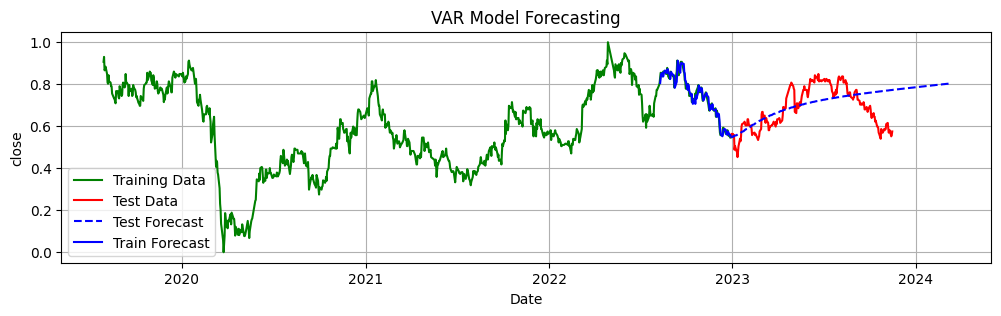

In [51]:
# Plot the results
plt.figure(figsize=(12, 3))

# Plot the training, test, and forecasted
plt.plot(data_train.index    , data_train[target]   , label='Training Data', color='green')
plt.plot(data_test.index     , data_test[target]    , label='Test Data'    , color='red')
plt.plot(forecast_data.index , forecast_data[target], label='Test Forecast', color='blue', linestyle='--')

plt.plot(data_train.index[lag_order + len(data_train[lag_order:])-100:],
         model_fitted.fittedvalues.values[len(data_train[lag_order:])-100:, -1],
         label='Train Forecast', color='blue')

plt.title('VAR Model Forecasting')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.show()

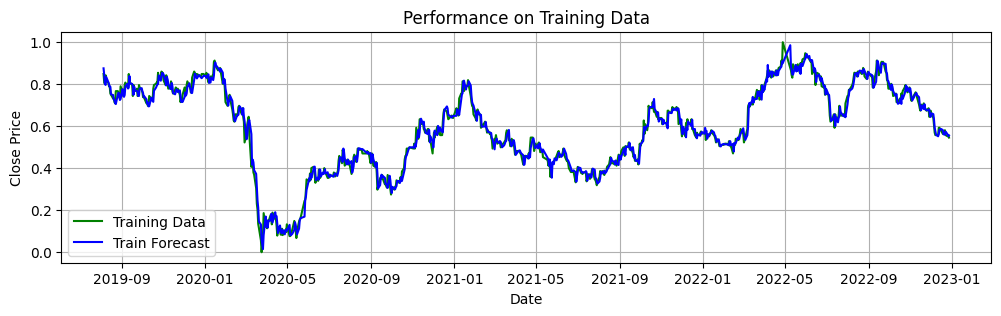

In [52]:
# Performance on Training Data
plt.figure(figsize=(12, 3))
plt.plot(data_train[lag_order:].index, data_train[lag_order:]['close']  , label='Training Data' , color='green')
plt.plot(data_train[lag_order:].index, model_fitted.fittedvalues.values[:, -1], label='Train Forecast', color='blue')
plt.title('Performance on Training Data')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

In [53]:
# Calculate residuals (errors) on the training data
train_residuals = data_train[lag_order:]['close'] - model_fitted.fittedvalues.values[:, -1]
test_residuals = data_test['close'] - forecast_data['close']

# Calculate Mean Squared Error (MSE) for each variable
train_MSE = mean_squared_error(data_train[lag_order:]['close'], model_fitted.fittedvalues.values[:, -1])
test_MSE = mean_squared_error(data_test['close'], forecast_data[:-100]['close'])

# Print the MSE for each feature
print("Close Price MSE on Training Data:", train_MSE)
print("Close Price MSE on Test Data:", test_MSE)

Close Price MSE on Training Data: 0.0007899643711769598
Close Price MSE on Test Data: 0.007720944211397492


## **Save the Model**

In [54]:
# Menyimpan model VAR ke dalam file menggunakan pickle
with open('model_var.pkl', 'wb') as f:
    pickle.dump(model_fitted, f)

In [55]:
# Untuk memuat kembali model dari file
with open('model_var.pkl', 'rb') as f:
    model_fitted = pickle.load(f)

## **Forecast in the Future**

In [56]:
# Number of predicted time steps
steps = 250

# Predict use VAR model
forecast       = model_fitted.forecast(data_test.values, steps = steps)
forecast_index = pd.date_range(start=data_test.index[-1], freq='B', periods=steps + 1)[1:]
forecast_data  = pd.DataFrame(forecast, index=forecast_index, columns=data_test.columns)
forecast_data.head()

,weight_for_index,foreign_sell,volume,close
2023-11-16,-0.004543,0.118770,0.103801,0.574480
2023-11-17,-0.007490,0.120372,0.103729,0.575478
2023-11-20,-0.009823,0.127444,0.111584,0.574404
2023-11-21,-0.013971,0.130804,0.117515,0.577592
2023-11-22,-0.016706,0.139317,0.128093,0.580010


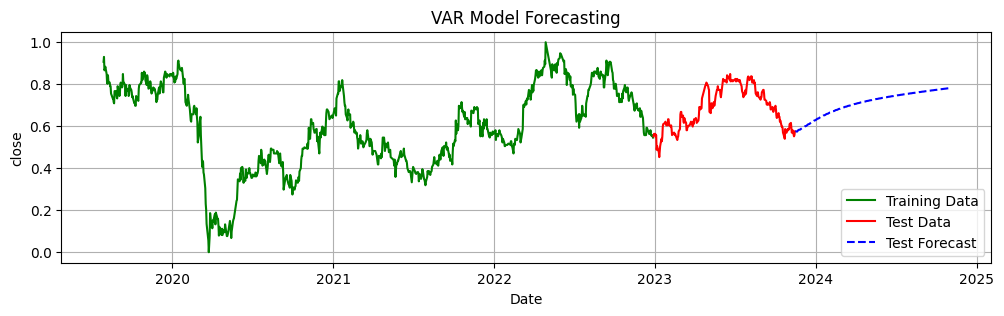

In [57]:
# Plot the results
plt.figure(figsize=(12, 3))

# Plot the training, test, and forecasted
plt.plot(data_train.index    , data_train[target]   , label='Training Data', color='green')
plt.plot(data_test.index     , data_test[target]    , label='Test Data'    , color='red')
plt.plot(forecast_data.index , forecast_data[target], label='Test Forecast', color='blue', linestyle='--')

plt.title('VAR Model Forecasting')
plt.xlabel('Date')
plt.ylabel(target)
plt.legend()
plt.grid(True)
plt.show()